# oscar virtual maps in cavity

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import finesse
import finesse.analysis.actions as fac
# finesse.init_plotting()

import numpy as np
import finesse.knm.maps as fmaps
import finesse.utilities.maps as fmutil

In [2]:
def plotMap(surf, plot_r=None, zlims=[None,None],pad=0.01):
    
    Zvals=surf.opd.copy()
    
    #clip off regions outside the mirror, or specified plotting radius
    if plot_r is None: 
        plot_r = max(max(surf.x),max(surf.y))/2
    clip = fmutil.circular_aperture(surf.x, surf.y, plot_r)
    clip[clip==0]=np.NaN
    Zvals*=clip
        
    #plot it
    fig,ax=plt.subplots(figsize=(5,4), tight_layout=True)
    smap = ax.pcolormesh(surf.x,surf.y,Zvals,cmap='viridis',
                            vmin=zlims[0], vmax=zlims[1]
                           )
    cbar = plt.colorbar(smap, ax=ax)
    cbar.set_label('opd')
    ax.set(xlabel='x [m]', ylabel='y [m]',xlim=(-plot_r-pad,plot_r+pad), ylim=(-plot_r-pad,plot_r+pad))
    return

## base model

In [24]:
model=finesse.Model()
model.parse("""
l i1 1
s sin i1.p1 NI.p1

m NI T=0.014 L=0 Rc=-1425 
s LN NI.p2 NE.p1 L=2999.8
m NE T=5u L=0 Rc=1695
cav cavN NI.p2.o
modes(maxtem=10)

# some useful detectors
pd Pc NI.p2.o
pd Pr NI.p1.o
pd Pt NE.p2.o
mathd Loss (1-Pr-Pt)
ad A00 NI.p2.o n=0 m=0 f=0
fd Fc NI.p2.o f=0
fd Fr NI.p1.o f=0
""")


In [4]:
model.run()
model.NI.p1.i.qy.w, model.NI.p1.i.qy.Rc 

(0.04684679708866172, -1424.9999999999998)

In [5]:
# input q: 
# w = 0.0468468
# R -982.759

# IM
# remove tilt and curvature in 16cm area. [[Forced rms inside 0.5e-9]]

# #aperture 0.33m

In [35]:
def testmap(mapfile, mapvectorfile, basemodel,aperture=0.33, plotmap=True):
    
    #get the spotsize on the input mirror
    with model.temporary_parameters():
        model.modes(maxtem=0)
        model.run()
        spotsize =  model.NI.p2.o.qy.w
        print('spotsize for weighting:', spotsize)
    
    ##prepare the apertures
    x = y = np.loadtxt(mapvectorfile,delimiter=',')
    if aperture:
        map_r = aperture
    else:
        map_r = max(x)
    aper = fmutil.circular_aperture(x, y, map_r)
    
    #map preparation
    data = np.loadtxt(mapfile,delimiter=',')
    data[np.isnan(data)] = 0     #replace NaNs with zeros
    surf = fmaps.Map(x,y,
                opd=data,
                amplitude=aper) #F3 map object
    linterms = surf.remove_tilts(spotsize)     #remove tilt
    quadterms = surf.remove_curvatures(spotsize)     #remove curvature
    # #remove dc offset - method based on pykat's removeOffset
    r = spotsize
    X,Y=np.meshgrid(x,y)
    rho = np.sqrt(X**2 + Y**2) #fromCreatePolarGrid
    inside = rho<r
    inside_notNan = np.zeros(inside.shape,dtype=bool)
    map_opd=np.asarray(surf.opd)
    inside_notNan[inside] = map_opd[inside] #boolean mask, true if map_opd has a value & inside r
    offset = map_opd[inside_notNan].sum()/inside_notNan.sum() #mean of vaues inside r
    map_opd-=offset
    
    if plotmap:
        plotMap(surf)
    
    RMS = np.std(map_opd - map_opd.mean(axis=0))
    print('map RMS (standard deviation) = ',RMS)
    
    #run the simulation
    with model.temporary_parameters():
        model.modes(maxtem=10)
        #apply map and aperture
        model.NI.surface_map = surf
        model.NE.surface_map = fmaps.Map(x,y,amplitude=aper) 
        # model.run(## MAXIMIZE Pcirc
        o=model.run()
        
        model.NE.misaligned=True
        o2 = model.run()

    print(f"""
    powers with map, maxtem 10
    Pc   {o['Pc']:>8.2f} W 
    Pc00 {abs(o['A00'])**2:>8.2f} W  ( {abs(o['A00'])**2/o['Pc']*100} %)
    Pr   {o['Pr']:>8.2f} W
    Pt   {o['Pt']:>8.2f} W
    Loss {o['Loss']*1e6:>8.2f} ppm
    """)
    
    fig,ax=plt.subplots(figsize=(12,4))
    ax.bar(model.hom_labels, abs(o['Fc'])**2, label=mapfile)
    ax.set(yscale='log',xlabel='HOM',ylabel='Power [W]', title='circulating fields')
    ax.tick_params(axis='x', labelrotation = 90)
    ax.margins(x=0)
    
    fig,ax=plt.subplots(figsize=(12,4))
    ax.bar(model.hom_labels, abs(o2['Fr'])**2, label=mapfile)
    ax.set(yscale='log',xlabel='HOM',ylabel='Power [W]', title = 'directly reflected')
    ax.tick_params(axis='x', labelrotation = 90)
    ax.margins(x=0)
    return

spotsize for weighting: 0.04684679708866172
map RMS (standard deviation) =  2.7469576321464573e-10

    powers with map, maxtem 10
    Pc     283.51 W 
    Pc00   283.51 W  ( 99.99998622457447 %)
    Pr       1.00 W
    Pt       0.00 W
    Loss     1.56 ppm
    


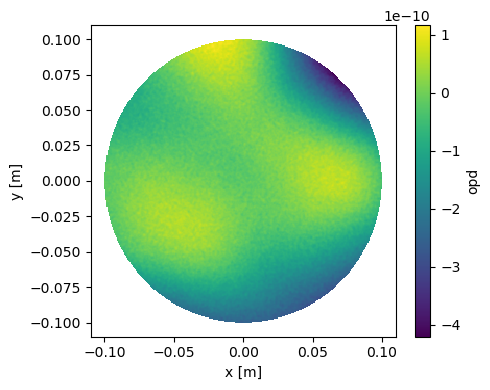

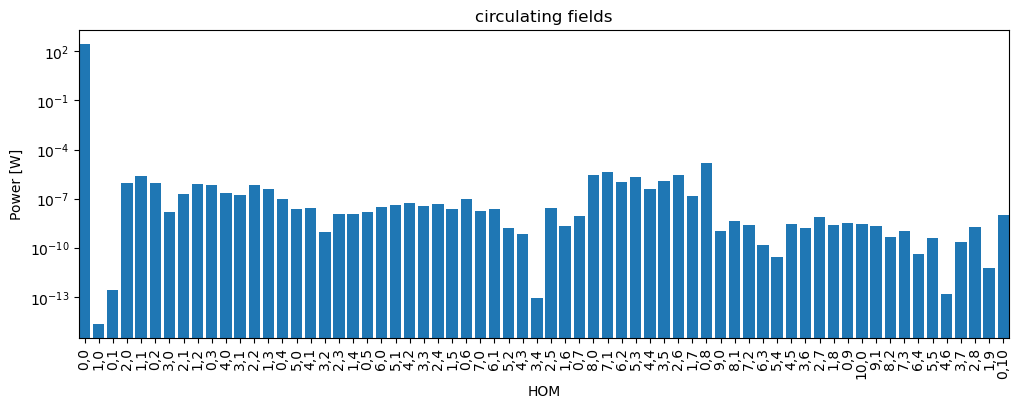

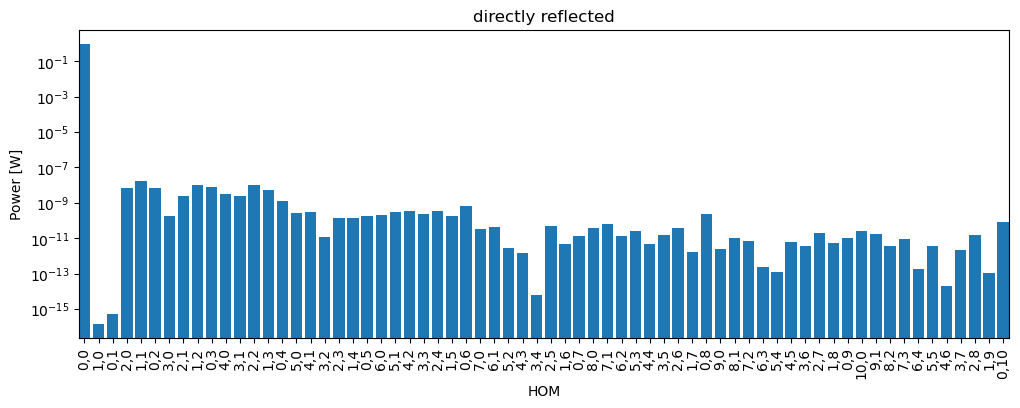

In [36]:
testmap("maps/im02_fake.txt", "maps/im02_fake_vector.txt", model,aperture=0.33, plotmap=True)